In [ ]:
!pip install contractions
!pip install twython

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import keras
import pickle
import re
import nltk
import tensorflow_hub as hub

from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, GRU
from tensorflow.keras.layers import GlobalMaxPool1D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

from utilities import *

sns.set_style('whitegrid');
sns.set_context('notebook', font_scale=1.2);

In [3]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
root = '/content/drive/My Drive/surely_not_sarcasm_data/'

# get data

In [6]:
df = pd.read_csv(root+'data/train_balanced_smaller.csv', usecols=['comment', 'label'])
df.head()

,label,comment
0,0,NC and NH.
1,0,You do know west teams play against west teams...
2,0,"They were underdogs earlier today, but since G..."
3,0,"This meme isn't funny none of the ""new york ni..."
4,0,I could use one of those tools.


In [7]:
X = df['comment'].values
y = df['label'].values

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train, test_size=0.05, random_state=42)

In [9]:
X_train.shape, X_val.shape, X_test.shape

((768187,), (202155,), (40431,))

In [10]:
data = pickle.load(open(root+'preprocessed_data_1503', 'rb'))

# tokenize

In [11]:
input_dim = 10000
tokenizer = Tokenizer(num_words=input_dim, filters='')
tokenizer.fit_on_texts(data['X_train'])

In [12]:
X_train_tok = tokenizer.texts_to_sequences(data['X_train'])
X_val_tok = tokenizer.texts_to_sequences(data['X_val'])
X_test_tok = tokenizer.texts_to_sequences(data['X_test'])

In [13]:
np.quantile([len(i) for i in X_train_tok], 0.9)

22.0

In [14]:
maxlen = 20

In [15]:
X_train_tok = pad_sequences(X_train_tok, padding='post', maxlen=maxlen)
X_val_tok = pad_sequences(X_val_tok, padding='post', maxlen=maxlen)
X_test_tok = pad_sequences(X_test_tok, padding='post', maxlen=maxlen)

# some random shit

In [21]:
model = keras.Sequential([
    hub.KerasLayer('https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1',
                   dtype=tf.string, input_shape=[], output_shape=[50], trainable=True),
    # tf.keras.layers.GRU(50),
    Dense(50, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, restore_best_weights=True)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(X_train, y_train, validation_data=(X_val,y_val), batch_size=128, epochs=50, callbacks=[es])

Epoch 1/50
6002/6002 [==============================] - 194s 32ms/step - loss: 0.5870 - accuracy: 0.6843 - val_loss: 0.5657 - val_accuracy: 0.7033
Epoch 2/50
6002/6002 [==============================] - 192s 32ms/step - loss: 0.5462 - accuracy: 0.7209 - val_loss: 0.5636 - val_accuracy: 0.7056
Epoch 3/50
6002/6002 [==============================] - 196s 33ms/step - loss: 0.5218 - accuracy: 0.7392 - val_loss: 0.5690 - val_accuracy: 0.7056
Epoch 4/50
6002/6002 [==============================] - 196s 33ms/step - loss: 0.4994 - accuracy: 0.7545 - val_loss: 0.5757 - val_accuracy: 0.7040
Epoch 5/50
6002/6002 [==============================] - 197s 33ms/step - loss: 0.4789 - accuracy: 0.7680 - val_loss: 0.5896 - val_accuracy: 0.7028


# embedding matrix

In [ ]:
vec_len = 100

In [ ]:
wordemb = WordEmbeddings()
embedding_matrix = wordemb.get_glove_embeddings(input_dim, vec_len, tokenizer, root=root)

coverage: 0.9815


# CNN

In [ ]:
model = Sequential([
    Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen,
              mask_zero=True, weights=[embedding_matrix], trainable=True),

    Conv1D(32, 2, activation='relu', kernel_initializer='he_normal', padding='same'),
    BatchNormalization(),
    Conv1D(32, 2, activation='relu', kernel_initializer='he_normal', padding='same'),
    BatchNormalization(),
    MaxPooling1D(2, padding='same'),
    Dropout(0.3),

    Conv1D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same'),
    BatchNormalization(),
    Conv1D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same'),
    BatchNormalization(),
    MaxPooling1D(3, padding='same'),
    Dropout(0.3),

    Flatten(),
    Dense(100, activation='elu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, restore_best_weights=True)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(X_train_tok, y_train, validation_data=(X_val_tok,y_val), batch_size=128, epochs=50, callbacks=[es])

Epoch 1/50
6002/6002 [==============================] - 100s 16ms/step - loss: 0.5966 - accuracy: 0.6790 - val_loss: 0.5527 - val_accuracy: 0.7170
Epoch 2/50
6002/6002 [==============================] - 96s 16ms/step - loss: 0.5459 - accuracy: 0.7244 - val_loss: 0.5394 - val_accuracy: 0.7271
Epoch 3/50
6002/6002 [==============================] - 100s 17ms/step - loss: 0.5301 - accuracy: 0.7362 - val_loss: 0.5340 - val_accuracy: 0.7298
Epoch 4/50
6002/6002 [==============================] - 96s 16ms/step - loss: 0.5172 - accuracy: 0.7461 - val_loss: 0.5327 - val_accuracy: 0.7318
Epoch 5/50
6002/6002 [==============================] - 96s 16ms/step - loss: 0.5058 - accuracy: 0.7544 - val_loss: 0.5383 - val_accuracy: 0.7249
Epoch 6/50
6002/6002 [==============================] - 100s 17ms/step - loss: 0.4946 - accuracy: 0.7625 - val_loss: 0.5375 - val_accuracy: 0.7283
Epoch 7/50
6002/6002 [==============================] - 100s 17ms/step - loss: 0.4843 - accuracy: 0.7698 - val_loss: 0.53

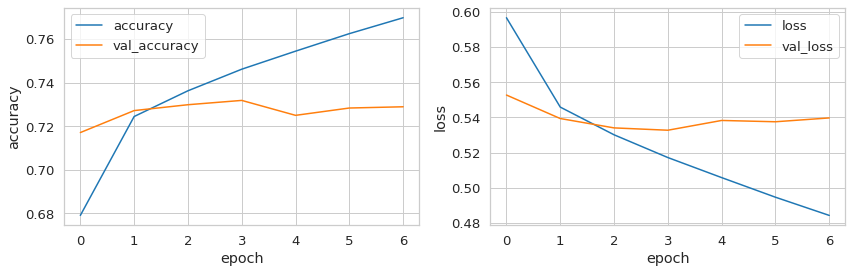

In [ ]:
plot_history(fit)

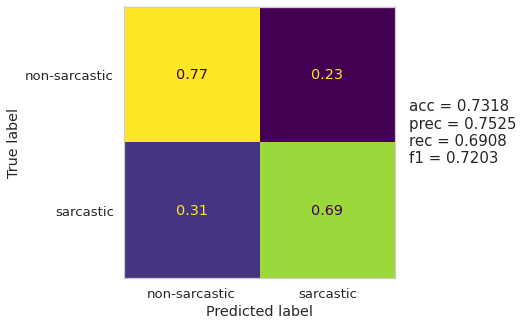

In [ ]:
evaluate(model, X_val_tok, y_val)

In [ ]:
show_errors(model, pd.Series(X_val), X_val_tok, y_val, n=5)

False negatives:
---------------------------
How about instead of making posters finish the Tool album.
Mario 64 came out about the same time, I still don't get why they didn't make Crash a 3D game
Redskins would still be all white if it was allowed.
Jesus
I think that's a bit too smart for Nintendo.

False positives:
---------------------------
Should have just turned, hit fenrir and flipped the ymir ult at the start...Wouldve taken sooo much less damage...
Can we modify the petition to have him replace Joe Buck forever?
It's almost like people who flag their ships in 3rd world shitholes do so because they care more about money than health and safety...
Gamestop is going to be the next Blockbuster.
Nah, guys like Curry/Kyrie/Westbrook/Rose/Hill aren't really traditional PGs


In [ ]:
model.save(root+'cnn')

INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/cnn/assets


# freezing

In [ ]:
embedding_layer = Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen,
                            mask_zero=True, weights=[embedding_matrix])
embedding_layer.trainable = False

In [ ]:
model = Sequential([
    embedding_layer,

    Conv1D(32, 2, activation='relu', kernel_initializer='he_normal', padding='same'),
    BatchNormalization(),
    Conv1D(32, 2, activation='relu', kernel_initializer='he_normal', padding='same'),
    BatchNormalization(),
    MaxPooling1D(2, padding='same'),
    Dropout(0.3),

    Conv1D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same'),
    BatchNormalization(),
    Conv1D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same'),
    BatchNormalization(),
    MaxPooling1D(3, padding='same'),
    Dropout(0.3),

    Flatten(),
    Dense(100, activation='elu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, restore_best_weights=True)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(X_train_tok, y_train, validation_data=(X_val_tok,y_val), batch_size=128, epochs=50, callbacks=[es])

Epoch 1/50
6002/6002 [==============================] - 81s 13ms/step - loss: 0.6267 - accuracy: 0.6495 - val_loss: 0.5917 - val_accuracy: 0.6811
Epoch 2/50
6002/6002 [==============================] - 80s 13ms/step - loss: 0.5811 - accuracy: 0.6928 - val_loss: 0.5986 - val_accuracy: 0.6798
Epoch 3/50
6002/6002 [==============================] - 83s 14ms/step - loss: 0.5707 - accuracy: 0.7021 - val_loss: 0.5758 - val_accuracy: 0.6957
Epoch 4/50
6002/6002 [==============================] - 78s 13ms/step - loss: 0.5658 - accuracy: 0.7060 - val_loss: 0.5577 - val_accuracy: 0.7107
Epoch 5/50
6002/6002 [==============================] - 79s 13ms/step - loss: 0.5616 - accuracy: 0.7095 - val_loss: 0.5765 - val_accuracy: 0.6941
Epoch 6/50
6002/6002 [==============================] - 83s 14ms/step - loss: 0.5593 - accuracy: 0.7115 - val_loss: 0.5538 - val_accuracy: 0.7143
Epoch 7/50
6002/6002 [==============================] - 83s 14ms/step - loss: 0.5572 - accuracy: 0.7131 - val_loss: 0.5643 -

In [ ]:
embedding_layer.trainable = True
adam = tf.keras.optimizers.Adam(0.0003)

In [ ]:
es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, restore_best_weights=True)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
fit2 = model.fit(X_train_tok, y_train, validation_data=(X_val_tok,y_val), batch_size=128, epochs=30, callbacks=[es])

Epoch 1/30
6002/6002 [==============================] - 100s 16ms/step - loss: 0.5428 - accuracy: 0.7249 - val_loss: 0.5350 - val_accuracy: 0.7291
Epoch 2/30
6002/6002 [==============================] - 98s 16ms/step - loss: 0.5287 - accuracy: 0.7359 - val_loss: 0.5431 - val_accuracy: 0.7255
Epoch 3/30
6002/6002 [==============================] - 98s 16ms/step - loss: 0.5200 - accuracy: 0.7425 - val_loss: 0.5342 - val_accuracy: 0.7308
Epoch 4/30
6002/6002 [==============================] - 94s 16ms/step - loss: 0.5126 - accuracy: 0.7479 - val_loss: 0.5295 - val_accuracy: 0.7332
Epoch 5/30
6002/6002 [==============================] - 94s 16ms/step - loss: 0.5065 - accuracy: 0.7524 - val_loss: 0.5303 - val_accuracy: 0.7335
Epoch 6/30
6002/6002 [==============================] - 98s 16ms/step - loss: 0.5012 - accuracy: 0.7571 - val_loss: 0.5292 - val_accuracy: 0.7334
Epoch 7/30
6002/6002 [==============================] - 95s 16ms/step - loss: 0.4960 - accuracy: 0.7603 - val_loss: 0.5382 

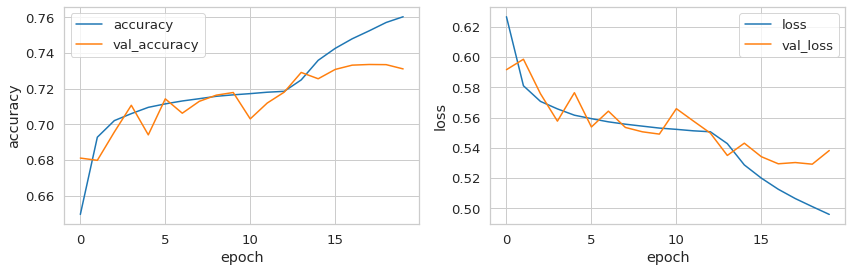

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14,4))

for i, which in enumerate(['accuracy', 'loss']):
    ax = axes[i]
    ax.plot(fit.history[which]+fit2.history[which], label=which)
    ax.plot(fit.history['val_'+which]+fit2.history['val_'+which], label='val_'+which)
    ax.set_xlabel('epoch')
    ax.set_ylabel(which)
    ax.legend();

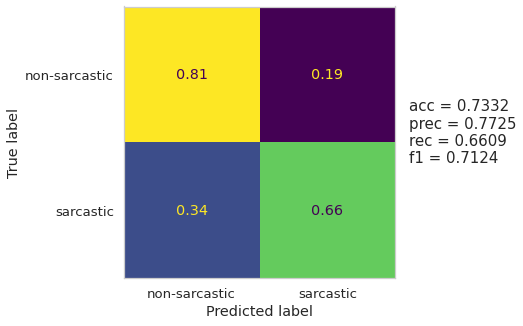

In [ ]:
evaluate(model, X_val_tok, y_val)

In [ ]:
show_errors(model, pd.Series(X_val), X_val_tok, y_val, n=5)

False negatives:
---------------------------
that would be inhumane
Where is your evidence to say that it is, because last time i checked there wasn't any.
My dick
common sense is no fun, party pooper...
Add some lights for the sun and it will be cool

False positives:
---------------------------
you sound like you're depressed, not "burnt out" with video games...
TIL there are plenty of holocaust skeptics on reddit.
Free access to information and the right to shit all over someone else's hard work are not one and the same
Not all search engines tailor their results per user ...
Jesus not everything is a conspiracy


In [ ]:
model.save(root+'cnn_freeze_unfreeze')

INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/cnn_freeze_unfreeze/assets


# freezing -- smaller learning rate

In [ ]:
embedding_layer = Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen,
                            mask_zero=True, weights=[embedding_matrix])
embedding_layer.trainable = False

In [ ]:
model = Sequential([
    embedding_layer,

    Conv1D(32, 2, activation='relu', kernel_initializer='he_normal', padding='same'),
    BatchNormalization(),
    Conv1D(32, 2, activation='relu', kernel_initializer='he_normal', padding='same'),
    BatchNormalization(),
    MaxPooling1D(2, padding='same'),
    Dropout(0.3),

    Conv1D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same'),
    BatchNormalization(),
    Conv1D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same'),
    BatchNormalization(),
    MaxPooling1D(3, padding='same'),
    Dropout(0.3),

    Flatten(),
    Dense(100, activation='elu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, restore_best_weights=True)
adam = tf.keras.optimizers.Adam(learning_rate=3e-4)

model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
fit = model.fit(X_train_tok, y_train, validation_data=(X_val_tok,y_val), batch_size=128, epochs=50, callbacks=[es])

Epoch 1/50
6002/6002 [==============================] - 80s 13ms/step - loss: 0.6734 - accuracy: 0.6066 - val_loss: 0.6122 - val_accuracy: 0.6625
Epoch 2/50
6002/6002 [==============================] - 83s 14ms/step - loss: 0.6024 - accuracy: 0.6723 - val_loss: 0.5805 - val_accuracy: 0.6916
Epoch 3/50
6002/6002 [==============================] - 82s 14ms/step - loss: 0.5848 - accuracy: 0.6885 - val_loss: 0.5729 - val_accuracy: 0.6982
Epoch 4/50
6002/6002 [==============================] - 83s 14ms/step - loss: 0.5761 - accuracy: 0.6964 - val_loss: 0.5661 - val_accuracy: 0.7054
Epoch 5/50
6002/6002 [==============================] - 79s 13ms/step - loss: 0.5704 - accuracy: 0.7013 - val_loss: 0.5619 - val_accuracy: 0.7074
Epoch 6/50
6002/6002 [==============================] - 82s 14ms/step - loss: 0.5661 - accuracy: 0.7048 - val_loss: 0.5610 - val_accuracy: 0.7084
Epoch 7/50
6002/6002 [==============================] - 82s 14ms/step - loss: 0.5637 - accuracy: 0.7068 - val_loss: 0.5607 -

In [ ]:
embedding_layer.trainable = True
adam = tf.keras.optimizers.Adam(1e-4)

In [ ]:
es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, restore_best_weights=True)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
fit2 = model.fit(X_train_tok, y_train, validation_data=(X_val_tok,y_val), batch_size=128, epochs=30, callbacks=[es])

Epoch 1/30
6002/6002 [==============================] - 98s 16ms/step - loss: 0.5508 - accuracy: 0.7180 - val_loss: 0.5442 - val_accuracy: 0.7219
Epoch 2/30
6002/6002 [==============================] - 96s 16ms/step - loss: 0.5422 - accuracy: 0.7242 - val_loss: 0.5395 - val_accuracy: 0.7260
Epoch 3/30
6002/6002 [==============================] - 96s 16ms/step - loss: 0.5360 - accuracy: 0.7299 - val_loss: 0.5373 - val_accuracy: 0.7277
Epoch 4/30
6002/6002 [==============================] - 100s 17ms/step - loss: 0.5308 - accuracy: 0.7338 - val_loss: 0.5367 - val_accuracy: 0.7287
Epoch 5/30
6002/6002 [==============================] - 98s 16ms/step - loss: 0.5264 - accuracy: 0.7376 - val_loss: 0.5334 - val_accuracy: 0.7306
Epoch 6/30
6002/6002 [==============================] - 97s 16ms/step - loss: 0.5224 - accuracy: 0.7407 - val_loss: 0.5343 - val_accuracy: 0.7302
Epoch 7/30
6002/6002 [==============================] - 93s 16ms/step - loss: 0.5188 - accuracy: 0.7433 - val_loss: 0.5324 

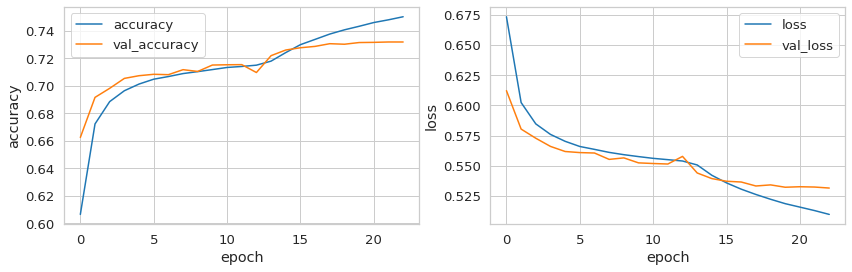

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14,4))

for i, which in enumerate(['accuracy', 'loss']):
    ax = axes[i]
    ax.plot(fit.history[which]+fit2.history[which], label=which)
    ax.plot(fit.history['val_'+which]+fit2.history['val_'+which], label='val_'+which)
    ax.set_xlabel('epoch')
    ax.set_ylabel(which)
    ax.legend();

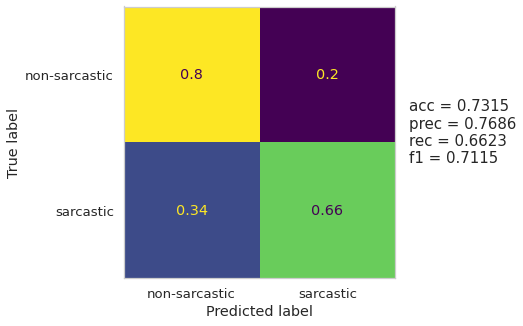

In [ ]:
evaluate(model, X_val_tok, y_val)

In [ ]:
show_errors(model, pd.Series(X_val), X_val_tok, y_val, n=5)

False negatives:
---------------------------
Ha....ha....ha
Then he should just get a running and swimming power meter.
I find the trademark for everyteam except mine offensive.
Go to church?
Well anecdotal evidence is basically proof in the scientific world and everyone on the internet tells the truth so I should upvote both of these comments and agree right?

False positives:
---------------------------
Just another day in the life of Good Guy Mike
rip, got 2 perkas from 8 3vat spins, problem are all those dlc ggs, its really lame to get only one perka from all those lds, hoping your luck change next time
If 'lol' stands for 'laugh out loud'... what is 'lel' supposed to mean?
Wouldn't it be more like, a bank employee decided to sneak you a bunch of money and you just took it and left without saying anything?
Nvidia GTX 480 cooling


In [ ]:
model.save(root+'cnn_freeze_unfreeze')

INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/cnn_freeze_unfreeze/assets


# CNN + polarity

In [ ]:
sia = SentimentIntensityAnalyzer()
polarity = data['X_train'].apply(lambda x: [sia.polarity_scores(w)['compound'] for w in x.split()])

In [ ]:
X_train_pol = np.zeros((polarity.shape[0], maxlen))

for row in range(polarity.shape[0]):
    vals = polarity.values[row]
    length = min(maxlen, len(vals))
    X_train_pol[row, :length] = vals[:length]

In [ ]:
sia = SentimentIntensityAnalyzer()
polarity_val = data['X_val'].apply(lambda x: [sia.polarity_scores(w)['compound'] for w in x.split()])

In [ ]:
X_val_pol = np.zeros((polarity_val.shape[0], maxlen))

for row in range(polarity_val.shape[0]):
    vals = polarity_val.values[row]
    length = min(maxlen, len(vals))
    X_val_pol[row, :length] = vals[:length]

In [ ]:
es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, restore_best_weights=True)

In [ ]:
X_train_pol = X_train_pol[..., None]

In [ ]:
X_val_pol = X_val_pol[..., None]

In [ ]:
model = Sequential([
    InputLayer(input_shape=(X_train_pol.shape[1], 1, )),
    Conv1D(32, 5, activation='relu', kernel_initializer='he_normal'),
    MaxPooling1D(5),
    Flatten(),
    Dense(100, activation='elu', kernel_initializer='he_normal'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(X_train_pol, y_train, validation_data=(X_val_pol,y_val), batch_size=128, epochs=50, callbacks=[es])

Epoch 1/50
6002/6002 [==============================] - 31s 5ms/step - loss: 0.6884 - accuracy: 0.5448 - val_loss: 0.6864 - val_accuracy: 0.5469
Epoch 2/50
6002/6002 [==============================] - 30s 5ms/step - loss: 0.6865 - accuracy: 0.5484 - val_loss: 0.6848 - val_accuracy: 0.5513
Epoch 3/50
6002/6002 [==============================] - 29s 5ms/step - loss: 0.6852 - accuracy: 0.5503 - val_loss: 0.6836 - val_accuracy: 0.5536
Epoch 4/50
6002/6002 [==============================] - 29s 5ms/step - loss: 0.6845 - accuracy: 0.5509 - val_loss: 0.6830 - val_accuracy: 0.5550
Epoch 5/50
6002/6002 [==============================] - 30s 5ms/step - loss: 0.6842 - accuracy: 0.5515 - val_loss: 0.6830 - val_accuracy: 0.5528
Epoch 6/50
6002/6002 [==============================] - 29s 5ms/step - loss: 0.6840 - accuracy: 0.5515 - val_loss: 0.6832 - val_accuracy: 0.5543


In [ ]:
model = Sequential([
    InputLayer(input_shape=(X_train_pol.shape[1], 1, )),
    Conv1D(32, 5, activation='relu', kernel_initializer='he_normal'),
    GRU(20),
    Dense(10, activation='elu', kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, restore_best_weights=True)
adam = tf.keras.optimizers.Adam(learning_rate=0.003)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
fit = model.fit(X_train_pol, y_train, validation_data=(X_val_pol,y_val), batch_size=128, epochs=50, callbacks=[es])

Epoch 1/50
6002/6002 [==============================] - 48s 8ms/step - loss: 0.6853 - accuracy: 0.5464 - val_loss: 0.6815 - val_accuracy: 0.5545
Epoch 2/50
6002/6002 [==============================] - 46s 8ms/step - loss: 0.6818 - accuracy: 0.5544 - val_loss: 0.6800 - val_accuracy: 0.5580
Epoch 3/50
6002/6002 [==============================] - 46s 8ms/step - loss: 0.6807 - accuracy: 0.5569 - val_loss: 0.6788 - val_accuracy: 0.5612
Epoch 4/50
6002/6002 [==============================] - 46s 8ms/step - loss: 0.6796 - accuracy: 0.5591 - val_loss: 0.6777 - val_accuracy: 0.5619
Epoch 5/50
6002/6002 [==============================] - 46s 8ms/step - loss: 0.6788 - accuracy: 0.5601 - val_loss: 0.6766 - val_accuracy: 0.5625
Epoch 6/50
6002/6002 [==============================] - 46s 8ms/step - loss: 0.6783 - accuracy: 0.5614 - val_loss: 0.6764 - val_accuracy: 0.5638
Epoch 7/50
6002/6002 [==============================] - 46s 8ms/step - loss: 0.6780 - accuracy: 0.5613 - val_loss: 0.6767 - val_ac

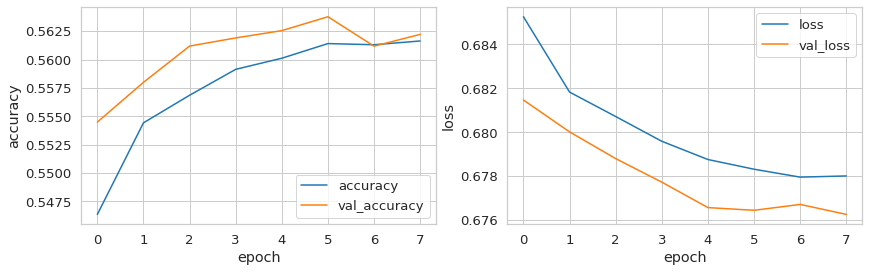

In [ ]:
plot_history(fit)

In [ ]:
model = Sequential([
    InputLayer(input_shape=(X_train_pol.shape[1], 1, )),
    Conv1D(32, 3, activation='relu', kernel_initializer='he_normal'),
    Conv1D(64, 5, activation='relu', kernel_initializer='he_normal'),
    GRU(20, return_sequences=True),
    GRU(20),
    Dense(10, activation='elu', kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, restore_best_weights=True)
adam = tf.keras.optimizers.Adam(learning_rate=0.003)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
fit = model.fit(X_train_pol, y_train, validation_data=(X_val_pol,y_val), batch_size=128, epochs=50, callbacks=[es])

In [ ]:
embeddings_input =  keras.Input(shape=(None,), name='embeddings')
polarity_input = keras.Input(shape=(X_train_pol.shape[1], 1, ), name='polarity')

emb = Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen,
                mask_zero=True, weights=[embedding_matrix], trainable=True)(embeddings_input)
emb = Conv1D(32, 3, activation='relu', kernel_initializer='he_normal')(emb)
# emb = MaxPooling1D(3)(emb)
# emb = Flatten()(emb)
emb = tf.keras.layers.GlobalMaxPooling1D()(emb)

pol = Conv1D(32, 5, activation='relu', kernel_initializer='he_normal')(polarity_input)
pol = GRU(20)(pol)

x = tf.keras.layers.concatenate([emb, pol])
x = Dense(100, activation='elu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, restore_best_weights=True)

model = keras.Model(inputs=[embeddings_input, polarity_input], outputs=[output])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit({'embeddings': X_train_tok, 'polarity': X_train_pol}, y_train, epochs=50, batch_size=128, callbacks=[es],
          validation_data=({'embeddings': X_val_tok, 'polarity': X_val_pol}, y_val))

Epoch 1/50
6002/6002 [==============================] - 86s 12ms/step - loss: 0.5772 - accuracy: 0.6942 - val_loss: 0.5507 - val_accuracy: 0.7172
Epoch 2/50
6002/6002 [==============================] - 72s 12ms/step - loss: 0.5374 - accuracy: 0.7287 - val_loss: 0.5441 - val_accuracy: 0.7212
Epoch 3/50
6002/6002 [==============================] - 77s 13ms/step - loss: 0.5183 - accuracy: 0.7428 - val_loss: 0.5413 - val_accuracy: 0.7239
Epoch 4/50
6002/6002 [==============================] - 76s 13ms/step - loss: 0.5001 - accuracy: 0.7562 - val_loss: 0.5500 - val_accuracy: 0.7208
Epoch 5/50
6002/6002 [==============================] - 72s 12ms/step - loss: 0.4821 - accuracy: 0.7690 - val_loss: 0.5623 - val_accuracy: 0.7165
Epoch 6/50
6002/6002 [==============================] - 76s 13ms/step - loss: 0.4642 - accuracy: 0.7806 - val_loss: 0.5667 - val_accuracy: 0.7166


In [ ]:
pol, emb

(<KerasTensor: shape=(None, 20) dtype=float32 (created by layer 'gru_3')>,
 <KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'global_max_pooling1d_1')>)

# polarity in embeddings

In [ ]:
sia = SentimentIntensityAnalyzer()
polarity_dim = np.zeros(input_dim)

for word, ind in tokenizer.word_index.items():
    if ind < input_dim:
        polarity_dim[ind] = sia.polarity_scores(word)['compound']

In [ ]:
emb_matrix_pol = np.concatenate([embedding_matrix, polarity_dim[:,None]], axis=1)

In [ ]:
model = Sequential([
    Embedding(input_dim=input_dim, output_dim=vec_len+1, input_length=maxlen,
              mask_zero=True, weights=[emb_matrix_pol], trainable=True),
              
    Conv1D(32, 2, activation='relu', kernel_initializer='he_normal', padding='same'),
    BatchNormalization(),
    Conv1D(32, 2, activation='relu', kernel_initializer='he_normal', padding='same'),
    BatchNormalization(),
    MaxPooling1D(2, padding='same'),
    Dropout(0.3),

    Conv1D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same'),
    BatchNormalization(),
    Conv1D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same'),
    BatchNormalization(),
    MaxPooling1D(3, padding='same'),
    Dropout(0.3),

    Flatten(),
    Dense(100, activation='elu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, restore_best_weights=True)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(X_train_tok, y_train, validation_data=(X_val_tok,y_val), batch_size=128, epochs=50, callbacks=[es])

Epoch 1/50
6002/6002 [==============================] - 104s 17ms/step - loss: 0.5981 - accuracy: 0.6798 - val_loss: 0.5490 - val_accuracy: 0.7187
Epoch 2/50
6002/6002 [==============================] - 114s 19ms/step - loss: 0.5465 - accuracy: 0.7234 - val_loss: 0.5386 - val_accuracy: 0.7276
Epoch 3/50
6002/6002 [==============================] - 94s 16ms/step - loss: 0.5308 - accuracy: 0.7354 - val_loss: 0.5355 - val_accuracy: 0.7289
Epoch 4/50
6002/6002 [==============================] - 95s 16ms/step - loss: 0.5179 - accuracy: 0.7455 - val_loss: 0.5384 - val_accuracy: 0.7290
Epoch 5/50
6002/6002 [==============================] - 93s 16ms/step - loss: 0.5069 - accuracy: 0.7534 - val_loss: 0.5355 - val_accuracy: 0.7302
Epoch 6/50
6002/6002 [==============================] - 97s 16ms/step - loss: 0.4962 - accuracy: 0.7609 - val_loss: 0.5343 - val_accuracy: 0.7303
Epoch 7/50
6002/6002 [==============================] - 104s 17ms/step - loss: 0.4860 - accuracy: 0.7675 - val_loss: 0.538

# polarity of comment and parent

In [ ]:
df = pd.read_csv(root+'data/train_balanced_smaller.csv')
df.head()

,label,comment,parent_comment
0,0,NC and NH.,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",deadass don't kill my buzz
4,0,I could use one of those tools.,Yep can confirm I saw the tool they use for th...


In [ ]:
sia = SentimentIntensityAnalyzer()

def get_sentiment(comment):
    return sia.polarity_scores(comment)['compound']

df['sent_comment'] = df['comment'].map(get_sentiment)
df['sent_parent'] = df['parent_comment'].map(get_sentiment)

In [ ]:
X = df[['sent_comment', 'sent_parent']].values

In [ ]:
X_train_sent, X_val_sent, y_train, _ = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train_sent, X_test_sent, y_train, _ = train_test_split(X_train_sent, y_train, stratify=y_train, test_size=0.05, random_state=42)

In [ ]:
embeddings_input =  keras.Input(shape=(None,), name='embeddings')
polarity_input = keras.Input(shape=(X_train_sent.shape[1],), name='polarity')

emb = Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen,
                mask_zero=True, weights=[embedding_matrix], trainable=True)(embeddings_input)

emb = Conv1D(32, 2, activation='relu', kernel_initializer='he_normal', padding='same')(emb)
emb = BatchNormalization()(emb)
emb = Conv1D(32, 2, activation='relu', kernel_initializer='he_normal', padding='same')(emb)
emb = BatchNormalization()(emb)
emb = MaxPooling1D(2, padding='same')(emb)
emb = Dropout(0.3)(emb)

emb = Conv1D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(emb)
emb = BatchNormalization()(emb)
emb = Conv1D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(emb)
emb = BatchNormalization()(emb)
emb = MaxPooling1D(3, padding='same')(emb)
emb = Dropout(0.3)(emb)

emb = tf.keras.layers.GlobalMaxPooling1D()(emb)

x = tf.keras.layers.concatenate([emb, polarity_input])
x = Dense(100, activation='elu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, restore_best_weights=True)

model = keras.Model(inputs=[embeddings_input, polarity_input], outputs=[output])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit({'embeddings': X_train_tok, 'polarity': X_train_sent}, y_train, epochs=50, batch_size=128, callbacks=[es],
          validation_data=({'embeddings': X_val_tok, 'polarity': X_val_sent}, y_val))

Epoch 1/50
6002/6002 [==============================] - 101s 16ms/step - loss: 0.6016 - accuracy: 0.6743 - val_loss: 0.5583 - val_accuracy: 0.7151
Epoch 2/50
6002/6002 [==============================] - 107s 18ms/step - loss: 0.5485 - accuracy: 0.7218 - val_loss: 0.5386 - val_accuracy: 0.7270
Epoch 3/50
6002/6002 [==============================] - 103s 17ms/step - loss: 0.5324 - accuracy: 0.7347 - val_loss: 0.5407 - val_accuracy: 0.7282
Epoch 4/50
6002/6002 [==============================] - 101s 17ms/step - loss: 0.5195 - accuracy: 0.7446 - val_loss: 0.5335 - val_accuracy: 0.7325
Epoch 5/50
6002/6002 [==============================] - 103s 17ms/step - loss: 0.5076 - accuracy: 0.7531 - val_loss: 0.5328 - val_accuracy: 0.7334
Epoch 6/50
6002/6002 [==============================] - 99s 17ms/step - loss: 0.4968 - accuracy: 0.7613 - val_loss: 0.5429 - val_accuracy: 0.7277
Epoch 7/50
6002/6002 [==============================] - 97s 16ms/step - loss: 0.4863 - accuracy: 0.7683 - val_loss: 0.5